# 加油平台-用户画像分组(RFM)

## 导入数据

In [1]:
import pandas as pd #导入Pandas
df_sales = pd.read_csv('加油订单数据.csv') #载入数据
df_sales.head() #显示头几行数据 

,订单id,订单金额,下单时间,油站,油品,油号,用户手机号
0,18159,150,2022-03-07 15:30:19,菏泽中国能源曹县站,汽油,92#,15222251797
1,18167,150,2022-03-08 10:57:24,烟台市弘润化工加油站,汽油,92#,13375353831
2,18168,150,2022-03-08 11:10:14,临沂石油商会立亮站,汽油,92#,13792998595
3,18262,150,2022-03-09 15:29:34,淄博颜山石油制品供应站,汽油,92#,13053334357
4,18270,150,2022-03-09 16:34:47,菏泽联盟石化玉中加油站,汽油,92#,15864437077


## 数据可视化-查看订单分布

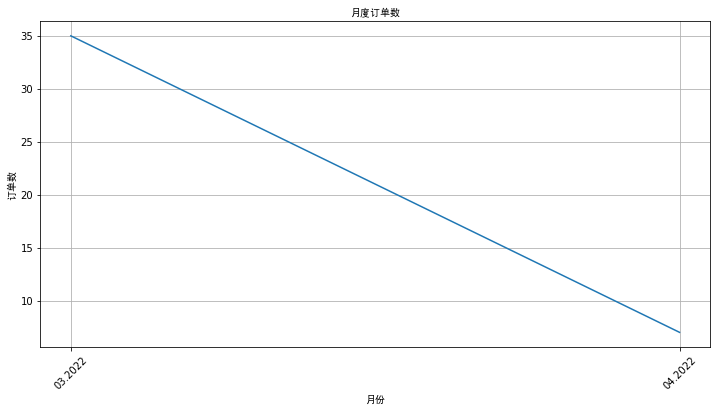

In [2]:
import matplotlib.pyplot as plt #导入Matplotlib的pyplot模块
from matplotlib.font_manager import FontProperties  #加载中文字体
font = FontProperties(fname='/Users/yunshixiong/Downloads/tmp/SimHei.ttf')

#构建月度的订单数的DataFrame
df_sales['下单时间'] = pd.to_datetime(df_sales['下单时间']) #转化日期格式
df_orders_monthly = df_sales.set_index('下单时间')['订单id'].resample('M').nunique()

#设定绘图的画布
ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True,figsize=(12,6),legend=False)
ax.set_xlabel('月份', fontproperties=font) # X轴label
ax.set_ylabel('订单数', fontproperties=font) # Y轴Label
ax.set_title('月度订单数', fontproperties=font) # 图题
#设定X轴月份显示格式
plt.xticks(
    range(len(df_orders_monthly.index)), 
    [x.strftime('%m.%Y') for x in df_orders_monthly.index], 
    rotation=45)
plt.show() # 绘图

## 数据清洗

In [3]:
df_sales = df_sales.drop_duplicates() #删除重复的数据行

In [4]:
df_sales.isna().sum() # 查看有NaN值出现的次数

订单id     0
订单金额     0
下单时间     0
油站       0
油品       0
油号       0
用户手机号    0
dtype: int64

In [5]:
df_sales.describe() #订单数据的统计信息-有无数据问题

,订单id,订单金额,用户手机号
count,42.000000,42.000000,4.200000e+01
mean,18344.857143,392.023810,1.439246e+10
std,57.006021,204.525207,1.834676e+09
min,18159.000000,150.000000,1.305333e+10
25%,18349.750000,200.000000,1.330641e+10
50%,18361.500000,500.000000,1.330641e+10
75%,18371.750000,500.000000,1.516246e+10
max,18391.000000,1000.000000,1.984089e+10


## 特征工程

## 构建用户表

In [6]:
df_user = pd.DataFrame(df_sales['用户手机号'].unique()) #生成以用户手机号为主键的结构df_user
df_user.columns = ['用户手机号'] #设定字段名
df_user = df_user.sort_values(by='用户手机号',ascending=True).reset_index(drop=True) #按用户手机号排序
df_user #显示df_user

,用户手机号
0,13053334357
1,13306409131
2,13361344225
3,13375353831
4,13792998595
5,13884757680
6,14753027577
7,15020471018
8,15158351175
9,15163826416


## 求R值-距离最近的下单天数

In [7]:
df_sales['下单时间'] = pd.to_datetime(df_sales['下单时间']) #转化日期格式
df_recent_buy = df_sales.groupby('用户手机号').下单时间.max().reset_index() #构建下单时间信息
df_recent_buy.columns = ['用户手机号','最近日期'] #设定字段名

df_recent_buy['R值'] = (df_recent_buy['最近日期'].max() - df_recent_buy['最近日期']).dt.days #计算最后一次订单日期与上次消费日期的天数
df_user = pd.merge(df_user, df_recent_buy[['用户手机号','R值']], on='用户手机号') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_user.head() #显示df_user头几行数据

,用户手机号,R值
0,13053334357,27
1,13306409131,4
2,13361344225,3
3,13375353831,28
4,13792998595,28


## 求F值-下单次数

In [8]:
df_frequency = df_sales.groupby('用户手机号').下单时间.count().reset_index() #计算每个用户消费次数
df_frequency.columns = ['用户手机号','F值'] #设定字段名称
df_user = pd.merge(df_user, df_frequency, on='用户手机号') #把消费频率整合至df_user结构
df_user.head() #显示头几行数据

,用户手机号,R值,F值
0,13053334357,27,1
1,13306409131,4,23
2,13361344225,3,1
3,13375353831,28,1
4,13792998595,28,1


## 求M值-下单总金额

In [9]:
df_revenue = df_sales.groupby('用户手机号').订单金额.sum().reset_index() #根据消费总额
df_revenue.columns = ['用户手机号','M值'] #设定字段名称
df_user = pd.merge(df_user, df_revenue, on='用户手机号') #把消费金额整合至df_user结构
df_user.head() #显示头几行数据

,用户手机号,R值,F值,M值
0,13053334357,27,1,150
1,13306409131,4,23,12500
2,13361344225,3,1,200
3,13375353831,28,1,150
4,13792998595,28,1,150


## 显示手肘图-辅助确定K值

In [10]:
from sklearn.cluster import KMeans #导入KMeans模块
def show_elbow(df): #定义手肘函数
    distance_list = [] #聚质心的距离（损失）
    K = range(1,9) #K值范围
    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=400) #创建KMeans模型
        kmeans = kmeans.fit(df) #拟合模型
        distance_list.append(kmeans.inertia_) #创建每个K值的损失
    plt.plot(K, distance_list, 'bx-') #绘图
    plt.xlabel('k') #X轴
    plt.ylabel('距离均方误差', fontproperties=font) #Y轴
    plt.title('k值手肘图', fontproperties=font) #标题

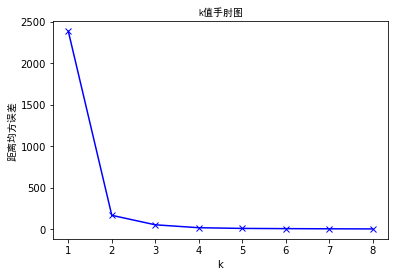

In [11]:
show_elbow(df_user[['R值']]) #显示R值聚类-K值手肘图

/var/folders/c4/6yftcsgx0lq1jd51_630ffd00000gn/T/ipykernel_4540/3239062814.py:7: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans = kmeans.fit(df) #拟合模型
/var/folders/c4/6yftcsgx0lq1jd51_630ffd00000gn/T/ipykernel_4540/3239062814.py:7: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = kmeans.fit(df) #拟合模型
/var/folders/c4/6yftcsgx0lq1jd51_630ffd00000gn/T/ipykernel_4540/3239062814.py:7: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  kmeans = kmeans.fit(df) #拟合模型
/var/folders/c4/6yftcsgx0lq1jd51_630ffd00000gn/T/ipykernel_4540/3239062814.py:7: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  kmeans = kmeans.fit(df) #拟合模型
/var/folders/c4/6yftcsgx0lq1jd51_630ffd00000

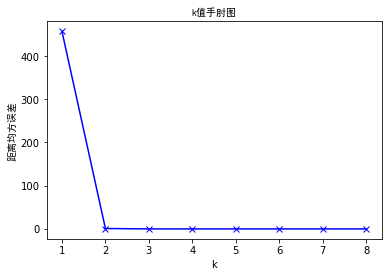

In [12]:
show_elbow(df_user[['F值']]) #显示F值聚类-K值手肘图

/var/folders/c4/6yftcsgx0lq1jd51_630ffd00000gn/T/ipykernel_4540/3239062814.py:7: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  kmeans = kmeans.fit(df) #拟合模型
/var/folders/c4/6yftcsgx0lq1jd51_630ffd00000gn/T/ipykernel_4540/3239062814.py:7: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  kmeans = kmeans.fit(df) #拟合模型


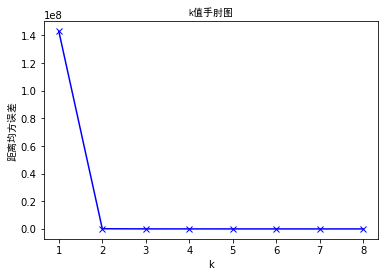

In [13]:
show_elbow(df_user[['M值']]) #显示M值聚类-K值手肘图

## 创建和训练模型-是用k-均值算法

In [14]:
from sklearn.cluster import KMeans #导入KMeans模块
kmeans_R = KMeans(n_clusters=3) #设定K=3
kmeans_F = KMeans(n_clusters=2) #设定K=4
kmeans_M = KMeans(n_clusters=2) #设定K=4

In [15]:
kmeans_R.fit(df_user[['R值']]) #拟合模型
kmeans_F.fit(df_user[['F值']]) #拟合模型
kmeans_M.fit(df_user[['M值']]) #拟合模型

KMeans(n_clusters=2)

## 给R值聚类

In [16]:
df_user['R值层级'] = kmeans_R.predict(df_user[['R值']]) #通过聚类模型求出R值的层级
df_user.head() #显示头几行数据

,用户手机号,R值,F值,M值,R值层级
0,13053334357,27,1,150,1
1,13306409131,4,23,12500,0
2,13361344225,3,1,200,0
3,13375353831,28,1,150,1
4,13792998595,28,1,150,1


In [17]:
df_user.groupby('R值层级')['R值'].describe() #R值层级分组统计信息

,count,mean,std,min,25%,50%,75%,max
R值层级,,,,,,,,
0,10.0,2.300000,2.057507,0.0,0.00,3.0,4.0,5.0
1,6.0,27.166667,1.471960,25.0,26.25,27.5,28.0,29.0
2,3.0,9.333333,1.154701,8.0,9.00,10.0,10.0,10.0


## 给聚类后的层级排序

In [18]:
#定义一个order_cluster函数为聚类排序
def order_cluster(cluster_name, target_name,df,ascending=False):
    df_new = df.groupby(cluster_name)[target_name].mean().reset_index() #按聚类结果分组，创建df_new对象
    df_new = df_new.sort_values(by=target_name,ascending=ascending).reset_index(drop=True) #排序
    df_new['index'] = df_new.index #创建索引字段
    df_new = pd.merge(df,df_new[[cluster_name,'index']], on=cluster_name) #基于聚类名称把df_new还原为df对象，并添加索引字段
    df_new = df_new.drop([cluster_name],axis=1) #删除聚类名称
    df_new = df_new.rename(columns={"index":cluster_name}) #将索引字段重命名为聚类名称字段
    return df_new #返回排序后的df_new对象

In [19]:
df_user = order_cluster('R值层级', 'R值', df_user, False) #调用簇排序函数
df_user = df_user.sort_values(by='用户手机号',ascending=True).reset_index(drop=True) #根据用户手机号排序
df_user.head() #显示头几行数据

,用户手机号,R值,F值,M值,R值层级
0,13053334357,27,1,150,0
1,13306409131,4,23,12500,2
2,13361344225,3,1,200,2
3,13375353831,28,1,150,0
4,13792998595,28,1,150,0


In [20]:
df_user.groupby('R值层级')['R值'].describe() #R值层级分组统计信息

,count,mean,std,min,25%,50%,75%,max
R值层级,,,,,,,,
0,6.0,27.166667,1.471960,25.0,26.25,27.5,28.0,29.0
1,3.0,9.333333,1.154701,8.0,9.00,10.0,10.0,10.0
2,10.0,2.300000,2.057507,0.0,0.00,3.0,4.0,5.0


## 继续给F、M值聚类，并排序

In [21]:
df_user['F值层级'] = kmeans_F.predict(df_user[['F值']]) #通过聚类模型求出F值的层级
df_user = order_cluster('F值层级', 'F值',df_user,True) #调用簇排序函数
df_user.groupby('F值层级')['F值'].describe() #F值层级分组统计信息

,count,mean,std,min,25%,50%,75%,max
F值层级,,,,,,,,
0,18.0,1.055556,0.235702,1.0,1.0,1.0,1.0,2.0
1,1.0,23.000000,NaN,23.0,23.0,23.0,23.0,23.0


In [22]:
df_user = df_user.sort_values(by='用户手机号',ascending=True).reset_index(drop=True) #根据用户手机号排序
df_user.head()

,用户手机号,R值,F值,M值,R值层级,F值层级
0,13053334357,27,1,150,0,0
1,13306409131,4,23,12500,2,1
2,13361344225,3,1,200,2,0
3,13375353831,28,1,150,0,0
4,13792998595,28,1,150,0,0


In [23]:
df_user['M值层级'] = kmeans_M.predict(df_user[['M值']]) #通过聚类模型求出M值的层级
df_user = order_cluster('M值层级', 'M值',df_user,True) #调用簇排序函数
df_user.groupby('M值层级')['M值'].describe() #M值层级分组统计信息
df_user = df_user.sort_values(by='用户手机号',ascending=True).reset_index(drop=True) #根据用户手机号排序
df_user.head() #显示头几行数据

,用户手机号,R值,F值,M值,R值层级,F值层级,M值层级
0,13053334357,27,1,150,0,0,0
1,13306409131,4,23,12500,2,1,1
2,13361344225,3,1,200,2,0,0
3,13375353831,28,1,150,0,0,0
4,13792998595,28,1,150,0,0,0


## 为用户整体分组画像

In [24]:
df_user['总分'] = df_user['R值层级'] + df_user['F值层级'] + df_user['M值层级'] #求出每个用户RFM总分

In [25]:
#在df_user对象中添加总体价值这个字段
df_user.loc[(df_user['总分']<=2) & (df_user['总分']>=0), '总体价值'] = '低价值' 
df_user.loc[(df_user['总分']<=4) & (df_user['总分']>=3), '总体价值'] = '中价值' 
df_user.loc[(df_user['总分']<=6) & (df_user['总分']>=5), '总体价值'] = '高价值'
df_user #显示df_user

,用户手机号,R值,F值,M值,R值层级,F值层级,M值层级,总分,总体价值
0,13053334357,27,1,150,0,0,0,0,低价值
1,13306409131,4,23,12500,2,1,1,4,中价值
2,13361344225,3,1,200,2,0,0,2,低价值
3,13375353831,28,1,150,0,0,0,0,低价值
4,13792998595,28,1,150,0,0,0,0,低价值
5,13884757680,25,1,200,0,0,0,0,低价值
6,14753027577,0,1,150,2,0,0,2,低价值
7,15020471018,8,1,300,1,0,0,1,低价值
8,15158351175,3,1,300,2,0,0,2,低价值
9,15163826416,10,1,200,1,0,0,1,低价值


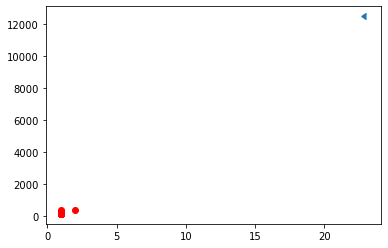

In [26]:
#显示高、中、低价值组-分布散点图（F值与M值）
plt.scatter(df_user.query("总体价值 == '高价值'")['F值'],
                   df_user.query("总体价值 == '高价值'")['M值'],c='g',marker='*')
plt.scatter(df_user.query("总体价值 == '中价值'")['F值'],
                   df_user.query("总体价值 == '中价值'")['M值'],marker=8)
plt.scatter(df_user.query("总体价值 == '低价值'")['F值'],
                   df_user.query("总体价值 == '低价值'")['M值'],c='r')